# 08-10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

데이터셋 설명
: 일본 대형 온라인 쇼핑몰 Mercari 사의 제품에 대해 가격을 예측하는 과제
: 데이터 세트는 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터로 구성 > 이를 기반으로 제품 예상 가격을 판매자들에게 제공
: 데이터 세트의 속성 (데이터 id, 제품명, 제품 상태, 카테고리 명, 브랜드 이름, price, 배송비 무료 여부, 제품에 대한 설명) >> price가 예측해야할 타깃 값

### 1.데이터 전처리

In [1]:
from sklearn.linear_model import Ridge,LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pandas as pd

mercari_df=pd.read_csv('/Users/bluecloud/Documents/대학/유런/데이터셋/mercari_train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [3]:
#피처 타입과 null 여부 확인하기
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


- brand_name : Null 값이 많다
- item_description,category_name  >> null값 존재
>> null 값 이후에 처리

<Figure size 600x400 with 0 Axes>

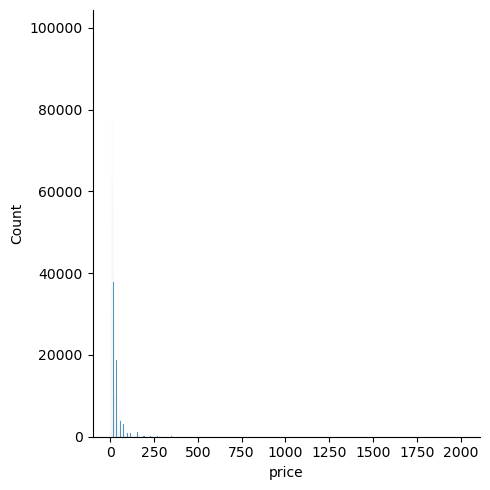

In [9]:
# price 칼럼 데이터 분포도 살펴보기
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
y_train_df=mercari_df['price']
plt.figure(figsize=(6,4))
sns.displot(y_train_df,kde=False)

- seaborn 업데이트해서 distplot >> displot으로
- price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡됨 >> price 칼럼을 로그 값으로 변환

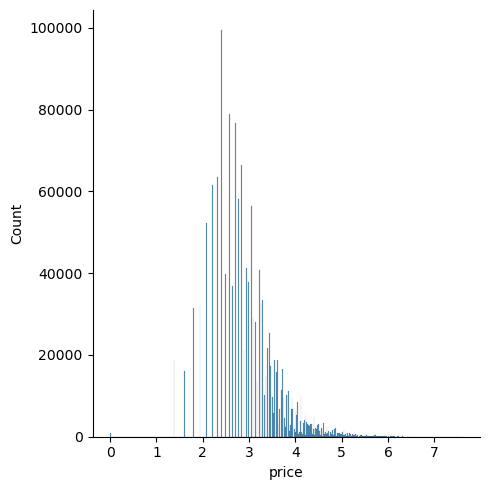

In [11]:
import numpy as np
y_train_df=np.log1p(y_train_df)
sns.displot(y_train_df,kde=False)

In [13]:
#데이터 세트의 price 칼럼을 원래 값에서 로그로 변환된 값으로 변경하기
mercari_df['price']=np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [15]:
# 다른 피처의 값 살펴보기
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    819435
1    663100
Name: count, dtype: int64
item_condition_id 값 유형:
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


- shipping : 배송비 유무 >> 1과 0으로 값이 균일
- item_condition_id : null값은 적지만 별도의 설명이 없는 경우 no description yet임 >> let's check it out

In [17]:
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

- category_name : '/'로 분리됨 >> /를 기준으로 단어를 토큰화해 별도의 피처로 저장
  별도의 함수 split_cat() : try/exception으로 Null 도 분리

In [19]:
#apply lambda에서 호출되는 대,중,소 분할 함수 생성 / 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_return','Other_return','Other_return']
# 위의 함수를 apply lambda에서 호출해 대중소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'],mercari_df['cat_jung'],mercari_df['cat_so']=zip(*mercari_df['category_name'].apply(lambda x:split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고 나머지는 분류 개수만 추출
print('대분류 유형 : \n',mercari_df['cat_dae'].value_counts())
print('중분류 유형 : \n',mercari_df['cat_jung'].nunique())
print('소분류 유형 : \n',mercari_df['cat_so'].nunique())

대분류 유형 : 
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_return                6327
Name: count, dtype: int64
중분류 유형 : 
 114
소분류 유형 : 
 871


>> women, Beauty, Kids 등의 분류가 많다

In [21]:
# 나머지 null값 Other_Null로 채우기
mercari_df['brand_name']=mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name']=mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description']=mercari_df['item_description'].fillna(value='Other_Null')
# null값이 다 채워졌나 확인
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

### 2. 피처 인코딩과 피처 벡터화

- 문자열 칼럼 중 레이블 또는 원-핫 인코딩을 수행 or 피처 벡터화로 변환할 칼럼을 선별
- 선형 회귀와 회귀 트리를 적용 >> 원-핫 인코딩 적용이 선호
- 피처 벡터화 : 짧은 텍스트 > Count 벡터화 / 긴 텍스트 : TD-IDF 기반 벡터화 적용

In [23]:
print('brand_name의 유형 건수 : ',mercari_df['brand_name'].nunique())
print('brand_name 샘플 5건 : \n',mercari_df['brand_name'].value_counts()[:5])

brand_name의 유형 건수 :  4810
brand_name 샘플 5건 : 
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


In [29]:
print('name의 유형 건수 : ',mercari_df['name'].nunique())
print('name 샘플 7건 : \n',mercari_df['name'][:7])

name의 유형 건수 :  1225273
name 샘플 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


- 피처 벡터화 : name > 유형 매우 많음 & 짧은 텍스트 > Count 벡터화
- category_name : 대중소 > 원-핫 인코딩
- shipping / item_condition_id : 0과1, 1~5가지의 유형의 값을 가지고 있음 > 원-핫 인코딩
- item_description : 가장 긴 텍스트

In [31]:
# 해당 칼럼의 평균 문자열 크기과 2개의 텍스트 추출해보기
pd.set_option('max_colwidth',200)
print('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

item_description 평균 문자열 개수: 145.71139703278507


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

>> item_description의 평균 문자열 개수가 145이므로 긴 텍스트 > TF-IDF로 변환해보기

In [33]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 피처 벡터화 변환 
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


- name > CountVectorizer()로 피처 벡터화 & fit_transform() >> 희소 행렬 반환
- item_description > TfidfVectorizer()로 피처 벡터화 & fit_transform() >> 희소 행렬 반환
>> 위의 두 희소 행렬 객체 변수를 결합해 새로운 데이터 세트로 구성
>> 나머지 피처 데이터들을 희소 행렬 형태로 인코딩 & 함께 결합
>> 희소 행렬 형태의 원-핫 인코딩 변환을 지원하는 LabelBinarizer() & 파라미터 설정 sparse_out=True

In [35]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name=LabelBinarizer(sparse_output=True)
X_brand=lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat 대중소 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae=LabelBinarizer(sparse_output=True)
X_cat_dae=lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung=LabelBinarizer(sparse_output=True)
X_cat_jung=lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so=LabelBinarizer(sparse_output=True)
X_cat_so=lb_cat_so.fit_transform(mercari_df['cat_so'])

In [37]:
# 인코딩 데이터 세트의 타입과 shape 살펴보기
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


- 인코딩 변환된 데이터 세트 : CSR 형태로 변환된 csr_matrix 타입
- 인코딩 칼럼이 매우 많지만 피처 벡터화로 텍스트 형태의 문자열이 갖는 벡터 형태의 매우 많은 칼럼과 결합됨 ㄱㅊ!

>> 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()으로 결합해보기
>> 메모리 용량을 많이 잡아먹으므로 데이터 타입과 크기 확인하고 삭제하기 with del'객체 변수명' / gc.collect()

In [39]:
from scipy.sparse import hstack
import gc

sparse_matrix_list=(X_name,X_descp,X_brand,X_item_cond_id,X_shipping,X_cat_dae,X_cat_jung,X_cat_so)

#hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse=hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse),X_features_sparse.shape)

#메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


43099

>> 모두 결합한 데이터 세트는 csr_matrix 타입이며 피처의 개수는 161569개이다

### 3. 릿지 회귀 모델 구축 및 평가

- 여러 알고리즘 모델의 예측 성능 비교 >> RMSLE(오류에 로그를 취해 RMSE를 구하는 방식>높은 가격에서 나는 큰 오류 값을 억제)
- 원본 price 값이 정규 분포 형태를 띄도록 로그 값을 취해 변환하기 & 다시 지수 변환 수행해 원복하기

In [61]:
def rmsle(y,y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

# 다시 지수 변환으로 원복하는 함수
def evaluate_org_price(y_test,preds):
    #원본 데이터는 exmpm1로 원복
    preds_exmpm=np.expm1(preds)
    y_test_exmpm=np.expm1(y_test)

    
    #rmsle로 RMSLE 추출
    rmsle_result=rmsle(y_test_exmpm,preds_exmpm)
    return rmsle_result

- 학습용 데이터 생성
- 모델 학습/예측하는 로직을 별도의 함수로 만들기

In [63]:
import gc
from scipy.sparse import hstack

# model인자로 회귀 estimator객체를, matrix_list 인자로 최종 데이터 세트로 결합할 희소 행렬 리스트를 가짐
def model_train_predict(model,matrix_list):
     #scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X=hstack(matrix_list).tocsr()
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'],test_size=0.2, random_state=156)
    # 모델 학습 및 예측
    model.fit(X_train,y_train)
    preds=model.predict(X_test)
    del X,X_train,X_test,y_train
    gc.collect()
    return preds,y_test

- 릿지로 mercari price 회귀 예측 수행하기
- before 예측 : 텍스트 형태의 속성이 얼마나 영향 미치는지 알아보기(포함되었을 때와 안 되었을 때의 예측 성능)

In [65]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.4984480211612475
Item Description을 포함한 rmsle 값: 0.4679507419600776


>> 포함했을 때 rmsle 값 많이 감소 : Item Description영향이 중요함

### 4. LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

- LightGBM을 이용해 회귀 수행 > 릿지와 LightGBM모델 예측값 간단한 앙상블 상식으로 섞기

In [67]:
from lightgbm import LGBMRegressor

sparse_matrix_list=(X_descp, X_name, X_brand, X_item_cond_id,X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 178.474603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068421
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 65338
[LightGBM] [Info] Start training from score 2.979514


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM rmsle 값: 0.4569987654210569


In [69]:
# 최종 예측 결괏값 : lgbm*0.45+linear*0.55 >> 앙상블한 데이터 세트로 예측 수행
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4468973140634917
